# Preamble: imports

Let's import some packages:

In [3]:
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as sck
import tensorflow
import os, shutil
import PIL
import matplotlib
import matplotlib.pyplot as plt

**Keras** is a high-level interface to **Tensorflow**, Google's framework for Deep Learning. Tensorflow:
- implements most types of neural layers (dense, convolutional and many more)
- implements many optimization algorithms
- automates the computation of forward and back-propagation

In [4]:
import keras

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten

from keras.layers.pooling import MaxPool2D
from keras.layers.convolutional import Conv2D

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


Some Jupyter options:

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Useful options from ```tpbasics.py```:

In [6]:
from tpbasics import img_numpy, show_img_file, elements_in_folder, n_elements_in_folder, \
    animate_files_in_dir, images_in_folder_numpy, numpy_max_activations, show_img_array

# Splashdown

## Basic info about our data

Picture folders: in each subfolder:
- ```.../Position_1```
- ```.../Position_2```
- ```.../Position_3```
- ```.../Position_4```

In [7]:
# folder of originals: full size
originals_dir = "pose_data/original"

# folder of downsampled pictures
downsampled_dir = "pose_data/downsampled"


# folder of training pictures
training_dir = "pose_data/training"

# folder of validation pictures
validation_dir = "pose_data/validation"

original_shape = (2976, 3968)
downsampled_shape = (2976 // 8, 3968 // 8)

## Visualizing images

Listing subfolders of our folder of originals:

In [8]:
os.listdir(originals_dir)

['Position_2', 'position_3', 'Position_4', 'Position_1']

Listing the files for one position - returns a list

In [17]:
os.listdir(originals_dir + "/Position_1")[0:3]
print(len(os.listdir(originals_dir + "/Position_1")))
print(len(os.listdir(originals_dir + "/Position_2")))
print(len(os.listdir(originals_dir + "/position_3")))
print(len(os.listdir(originals_dir + "/Position_4")))


182
213
201
232


Displaying one of the images

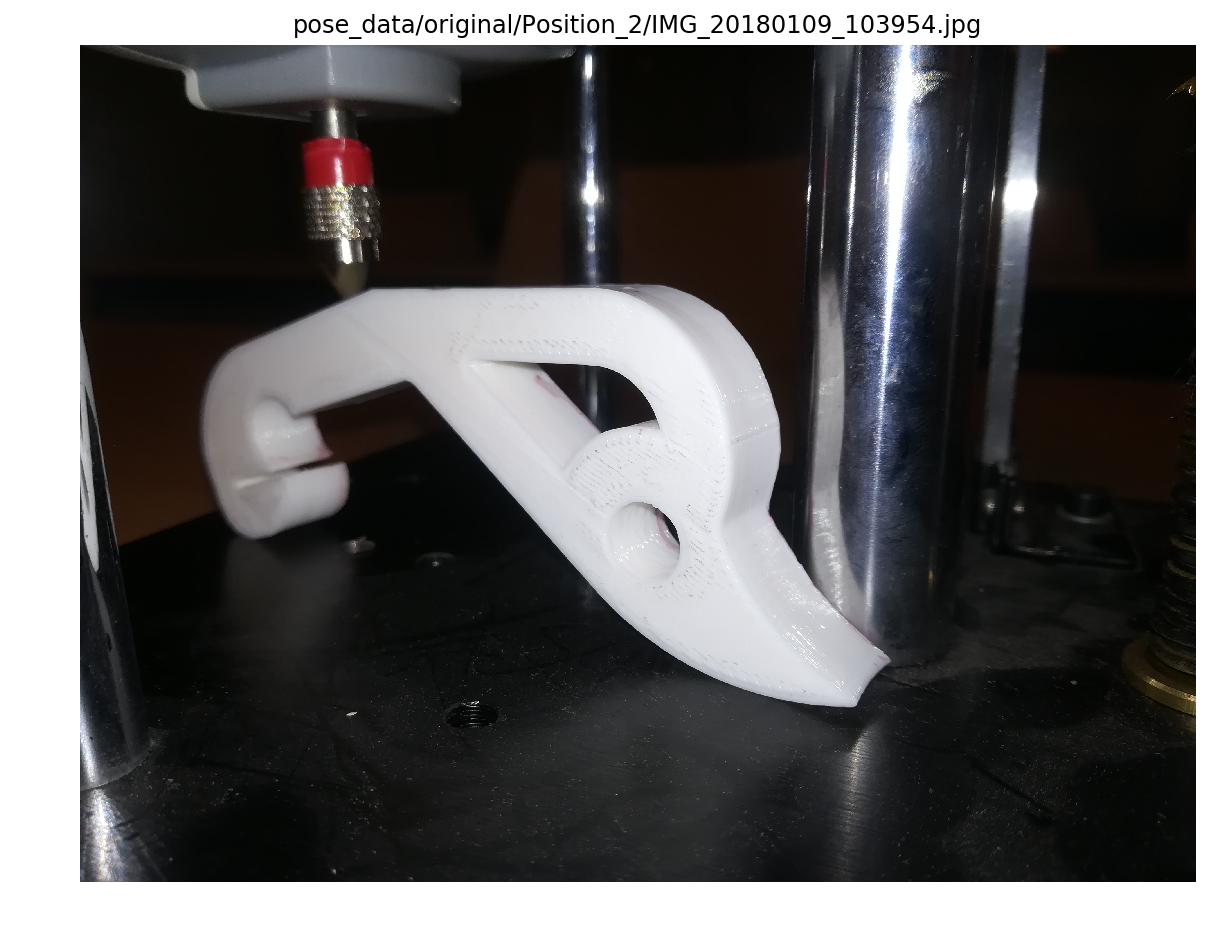

In [11]:
position_folder = originals_dir + "/Position_2"
img_path = position_folder + "/" + os.listdir(position_folder)[0]

show_img_file(img_path=img_path, figsize=(6, 4))

In [18]:
animate_files_in_dir(downsampled_dir + "/Position_4", figsize = (6, 4))

interactive(children=(IntSlider(value=0, description='x', max=231), Output()), _dom_classes=('widget-interact'…

# Classification

## Architecture A

Initialising the input object of our neural network:

In [20]:
image_input = Input(name="input_images", shape=downsampled_shape + (3,))

Successive activations are declared by:
- creating a new layer using a *constructor*, e.g. ```Conv2D(...)```, including the layer parameters
- applying this layer to the previous activations

In [21]:
# convolution + pooling 1
conv_1 = Conv2D(kernel_size=5, filters=8, strides=1, padding="valid", activation="relu")(image_input)
pool_1 = MaxPool2D(pool_size=4, strides=4)(conv_1)

# convolution + pooling 2
conv_2 = Conv2D(kernel_size=5, filters=8, strides=1, padding="valid", activation="relu")(pool_1)
pool_2 = MaxPool2D(pool_size=4, strides=4)(conv_2)

# convolution + pooling 3
conv_3 = Conv2D(kernel_size=5, filters=16, strides=1, padding="valid", activation="relu")(pool_2)
pool_3 = MaxPool2D(pool_size=4, strides=4)(conv_3)

# flattening
flat = Flatten()(pool_3)

# dense -> 64 (relu)
dense_1 = Dense(units=64, activation='relu')(flat)
drop_1 = Dropout(0.5)(dense_1)

# dense -> 4 (softmax)
probas = Dense(units=4, activation='softmax')(drop_1)

Creating a model that maps input to output, and compiling it by specifying:
- the loss function
- the optimizer
- the metric we want to monitor

In [22]:
classifier_A = Model(inputs=image_input, outputs=probas)
classifier_A.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model summary gives a succint view of the model, including output sizes and number of parameters:

In [23]:
classifier_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 372, 496, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 368, 492, 8)       608       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 92, 123, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 88, 119, 8)        1608      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 29, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 25, 16)        3216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 6, 16)          0         
__________

## Setting up data sources and augmentation

To decrease the chances of overfitting, we augment our initial training set with new images, obtained by applying random:
- rotations
- shear
- zoom
- horizontal and vertical flips


Synthetic images are produced in *batches* of size *batch_size*: training is done by optimizing using one batch at a time.

In [24]:
batch_size = 32

In [25]:
training_augmentation = ImageDataGenerator(
        rotation_range = 40,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

validation_augmentation = ImageDataGenerator(rescale=1./255)

In [26]:
training_generator = training_augmentation.flow_from_directory(
        directory=training_dir,
        batch_size=batch_size,
        class_mode='categorical',
        target_size=downsampled_shape)

Found 663 images belonging to 4 classes.


In [27]:
validation_generator = validation_augmentation.flow_from_directory(
        directory=validation_dir,
        batch_size=batch_size,
        class_mode='categorical',
        target_size=downsampled_shape)

Found 165 images belonging to 4 classes.


## Training

In [33]:
n_total_training_images_per_epoch = 1000
n_epochs = 10

n_total_validation_images_per_epoch = 200

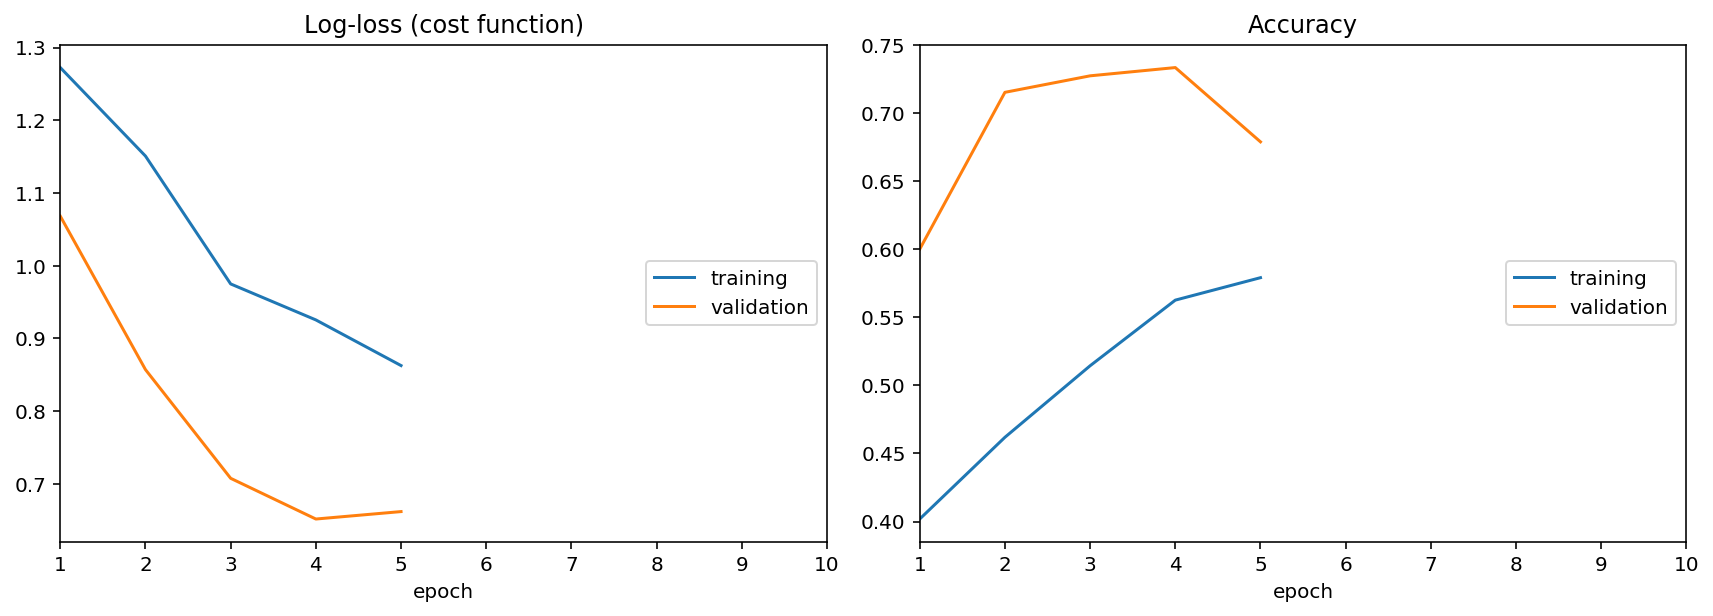

Log-loss (cost function):
training   (min:    0.862, max:    1.272, cur:    0.862)
validation (min:    0.651, max:    1.068, cur:    0.662)

Accuracy:
training   (min:    0.402, max:    0.579, cur:    0.579)
validation (min:    0.600, max:    0.733, cur:    0.679)

Epoch 00005: val_loss did not improve from 0.65139
Epoch 6/10
18/31 [================>.............] - ETA: 17s - loss: 0.8051 - acc: 0.6001

In [ ]:
history_A = classifier_A.fit_generator(
        generator=training_generator,
        steps_per_epoch=n_total_training_images_per_epoch // batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=n_total_validation_images_per_epoch // batch_size,
        callbacks = list([
            PlotLossesCallback(),
            keras.callbacks.ModelCheckpoint('cnn_models/classifier_A.h5',
                                                        monitor='val_loss',
                                                        verbose=1,
                                                        save_best_only=True),
            keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=5, 
                                                        verbose=1),]))

Models can be saved to / loaded from disk for re-use

In [30]:
classifier_A.save('cnn_models/classifier_A.h5')
classifier_A = keras.models.load_model('cnn_models/classifier_A.h5')

## Predictions

In [31]:
test_folder = training_dir + "/Position_2"
test_files = os.listdir(test_folder)

#####
test_file_index = 2

test_file_path = test_folder + "/" + test_files[test_file_index]

print("Testing: {0}".format(test_file_path))

Testing: pose_data/training/Position_2/IMG_20180109_103639_1.jpg


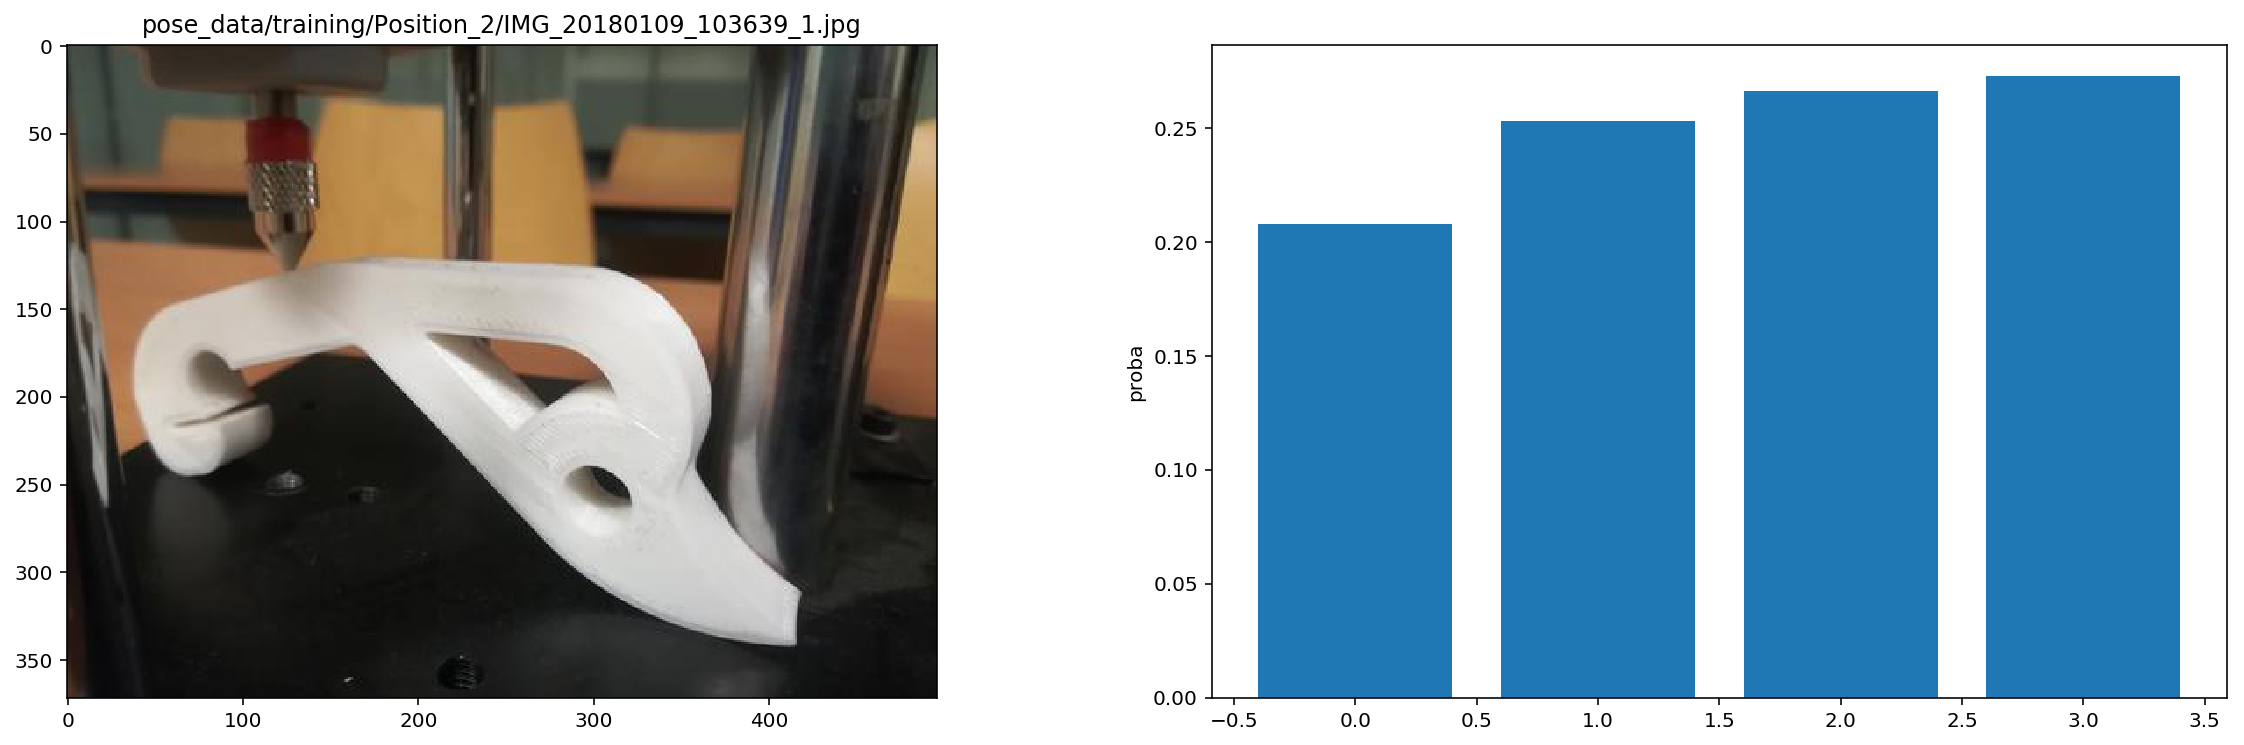

In [32]:
probas = classifier_A.predict(img_numpy(test_file_path)[np.newaxis, :, :, :] / 255.)

fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 6))

show_img_file(test_file_path, ax = axs[0])
axs[1].bar(height=probas[0,:], x = [0, 1, 2, 3])
axs[1].set_ylabel('proba')
plt.show()

## A close look at activations

In [ ]:
classifier_A.summary()

Importing all pictures from specified folder into a large array:

In [ ]:
all_pictures = images_in_folder_numpy(downsampled_dir + "/Position_1") / 255.

Extracting intermediate activations, and finding which patch from which figure maximizes each feature:

In [ ]:
first_layer = "conv2d_1"
activation_layer = "conv2d_3"
filter_sizes = [5, 4, 5, 4, 5]
strides = [1, 4, 1, 4, 1]

classifier_act_model = Model(inputs=classifier_A.get_layer(first_layer).input, 
                             outputs=classifier_A.get_layer(activation_layer).output)
classifier_activations = classifier_act_model.predict(all_pictures)

max_act_patches = numpy_max_activations(all_pictures, classifier_activations, filter_sizes, strides)

In [ ]:
i_feature = 1
i_image = 2

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(21, 7))
for ax in axs:
    ax.axis('off')
    
show_img_array(max_act_patches[i_feature], figsize=(7, 7), ax = axs[0])
show_img_array(all_pictures[i_image, :, :, :], figsize=(7, 7), ax = axs[1])
show_img_array(classifier_activations[i_image, :, :, i_feature], figsize=(7, 7), ax = axs[2])